<a href="https://colab.research.google.com/github/cyongkypranowo/DeepLearning-Gender-CLassification/blob/main/Tensorflow_Resnet101_CelebA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   Author: **C. Yongky Pranowo**
*   GitHub Repository: [DeepLearning-Gender-Classification](https://github.com/cyongkypranowo/DeepLearning-Gender-Classification)
*   Tools: **Google Colab / Jupyter Notebooks**
*   Architecture : CNN Gender Classifier (ResNet-101 Architecture with Dataset CelebA)

# **PROJECT : Face Recognition (Gender Classification)**

## **Introduction:**

Welcome to the Gender Classification Deep Learning project! In this notebook, we will explore the development of a gender classification model using deep learning techniques. The goal of this project is to accurately predict the gender of individuals based on their facial images.

We will leverage the powerful **ResNet101** architecture and optimize our model using hyperparameter tuning methods. The dataset consists of labeled facial images, which will be used for training, validation, and testing.

**ResNet101** is an extended version of the ResNet50 architecture, featuring 101 layers instead of 50. This deeper architecture allows for more complex feature extraction and representation learning, potentially leading to improved model performance.

Feel free to follow along with the code and experiment with different parameters and techniques. Let's dive in!

![ResNet101](https://raw.githubusercontent.com/rasbt/deeplearning-models/18e046926551378cd691fd871dda0f21dcd272ab/pytorch_ipynb/images/resnets/resnet101/resnet101-arch-1.png)

The ResNet-101 uses a bottleneck as shown below:
![image](https://raw.githubusercontent.com/rasbt/deeplearning-models/18e046926551378cd691fd871dda0f21dcd272ab/pytorch_ipynb/images/resnets/resnet-ex-1-3.png)

## What is ResNet-101?
ResNet-101 is a convolutional neural network architecture with 101 layers (99 convolutional layers and two pooling layers). This architecture is an extension of ResNet-50 and was introduced in a 2015 paper titled "Deep Residual Learning for Image Recognition" by He Kaiming, Zhang Xiangyu, Ren Shaoqing, and Sun Jian. Like ResNet-50, ResNet-101 also utilizes residual blocks to address the vanishing gradient problem and allows for adding more convolutional layers without sacrificing performance.

## ResNet-50 Architecture:
a. Initial Convolutional Layer: ResNet-101 starts with a 7x7 convolution using 64 kernels with a stride of 2.
b. Max Pooling Layer: Followed by a max pooling layer with a stride of 2.
c. Residual Block: The core of ResNet-101 consists of several residual blocks. Each block consists of three layers:
   - 3x3 convolution with 64 kernels.
   - 1x1 convolution with 64 kernels.
   - 1x1 convolution with 256 kernels. This block is repeated three times.
   Subsequent blocks have combinations of 1x1 and 3x3 convolutions with different numbers of kernels, repeated multiple times until reaching a total of 50 layers.

## Unique Features of ResNet-101:
- ResNet-101 also uses a bottleneck design in its blocks. This design employs 1x1 convolutions to reduce the number of parameters and matrix operations, resulting in faster training.
- The total floating-point operations (FLOPs) in ResNet-101 are 7.8 x 10^9.


# **Data Understanding**


## **Dataset** :

**Downloading the Dataset**

Note that the 202,599 CelebA face image dataset is relatively large (~1.3 Gb). The download link provided below was provided by the author on the official CelebA website at http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html.

However, the dataset we are using this time is a subset of the larger CelebA dataset.

1.   Download all [image](https://drive.google.com/drive/folders/1nnrQAoRy2IseVfeTY9QAFZ7vre6BP2xy?usp=drive_link), which contains the images in jpeg format, size 178x128 px
2.   Download [list_attribute.txt](https://drive.google.com/file/d/1rOo0zWLXQVBFMh8jWRge7Y65X_Q8c_dD/view?usp=drive_link) (file, which contains the class labels, we will split this file for 80% train,10% test, 10% evaluation)

## **Preparing the Dataset**

**Connect To GDrive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Install Keras Tuner**

In [2]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.2 MB/s eta 0:00:00


**Import required libraries for this project:**

In [19]:
from google.colab import drive
import os
import shutil
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

import keras_tuner as kt
from keras.models import Model, load_model
from keras.layers import Input, Flatten, Dense, Dropout, Conv2D, BatchNormalization, ReLU, AveragePooling2D, GlobalAveragePooling2D
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications import ResNet101
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
# Understand the data
df = pd.read_csv('/content/drive/MyDrive/ResNet/list_attribute.txt')
df

,202599
0,5_o_Clock_Shadow Arched_Eyebrows Attractive Ba...
1,000001.jpg -1 1 1 -1 -1 -1 -1 -1 -1 -1 -1 1...
2,000002.jpg -1 -1 -1 1 -1 -1 -1 1 -1 -1 -1 1...
3,000003.jpg -1 -1 -1 -1 -1 -1 1 -1 -1 -1 1 -1...
4,000004.jpg -1 -1 1 -1 -1 -1 -1 -1 -1 -1 -1 -1...
...,...
202595,202595.jpg -1 -1 1 -1 -1 -1 1 -1 -1 1 -1 -1...
202596,202596.jpg -1 -1 -1 -1 -1 1 1 -1 -1 1 -1 -1...
202597,202597.jpg -1 -1 -1 -1 -1 -1 -1 -1 1 -1 -1 -1...
202598,202598.jpg -1 1 1 -1 -1 -1 1 -1 1 -1 -1 -1...


In [5]:
# Reload the data & just use "Male" column for predict. The attribute "Male" might be chosen because the focus of the analysis or modeling is on gender classification
df = pd.read_csv('/content/drive/MyDrive/ResNet/list_attribute.txt', sep="\s+", skiprows=1, usecols=['Male'])
df


,Male
000001.jpg,-1
000002.jpg,-1
000003.jpg,1
000004.jpg,-1
000005.jpg,-1
...,...
202595.jpg,-1
202596.jpg,1
202597.jpg,1
202598.jpg,-1


In [6]:
# Set first column to "filename" and replace -1 to 0 for binary label
df.index.name = 'filename'
df.replace(to_replace=-1, value=0, inplace=True)
df

,Male
filename,
000001.jpg,0
000002.jpg,0
000003.jpg,1
000004.jpg,0
000005.jpg,0
...,...
202595.jpg,0
202596.jpg,1
202597.jpg,1


In [7]:
# in the "Male" column, 1 for "Male" & -1 for "Female", and replace the name to is_male
df.loc[df['Male'] == -1, 'Male'] = 0
df.rename(columns={"Male": "is_male"}, inplace=True)
df

,is_male
filename,
000001.jpg,0
000002.jpg,0
000003.jpg,1
000004.jpg,0
000005.jpg,0
...,...
202595.jpg,0
202596.jpg,1
202597.jpg,1


# **Data Cleaning & Analysis**

In [8]:
# Load filename from Images folder to get all of dataset filename
# This process essentially selects the rows of the DataFrame corresponding to the images available in the Images directory
image_files = os.listdir('/content/drive/MyDrive/ResNet/Images/')
filtered_df = df[df.index.isin(image_files)]
filtered_df

,is_male
filename,
000051.jpg,1
000052.jpg,1
000065.jpg,1
000166.jpg,1
000198.jpg,0
...,...
202320.jpg,0
202340.jpg,0
202347.jpg,0


In [9]:
# Reset index after filtering, it will reset the index of the DataFrame and display the index
filtered_df.reset_index(drop=False, inplace=True)
filtered_df

,filename,is_male
0,000051.jpg,1
1,000052.jpg,1
2,000065.jpg,1
3,000166.jpg,1
4,000198.jpg,0
...,...,...
4995,202320.jpg,0
4996,202340.jpg,0
4997,202347.jpg,0
4998,202357.jpg,0


In [10]:
# Prepare setup Path for image master, splitted image, train, validation, and test
images_path = '/content/drive/MyDrive/ResNet/Images'
splitted_folder = '/content/drive/MyDrive/ResNet/Splitted'
train_folder = os.path.join(splitted_folder, 'Train')
validation_folder = os.path.join(splitted_folder, 'Validation')
test_folder = os.path.join(splitted_folder, 'Test')

In [11]:
# Create directory for train_folder, validation and test in Splitted folder
os.makedirs(train_folder, exist_ok=True)
os.makedirs(validation_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

In [13]:
for index, row in filtered_df.iterrows():
    filename = row['filename']
    is_male_label = row['is_male']

    if index % 10 < 8:
        current_folder = train_folder
    elif index % 10 == 8:
        current_folder = validation_folder
    else:
        current_folder = test_folder

    if is_male_label == 0:
        is_male_folder = os.path.join(current_folder, 'Female')
    else:
        is_male_folder = os.path.join(current_folder, 'Male')

    os.makedirs(is_male_folder, exist_ok=True)

    source_path = os.path.join(images_path, filename)
    destination_path = os.path.join(is_male_folder, filename)

    if not os.path.exists(destination_path):
        print(f'Copying file {source_path} to {is_male_folder}')
        shutil.copy(source_path, destination_path)
    else:
        print(f'File {filename} already exists in {is_male_folder}, skipping.')

print('Splitting Datasets completed')

Output streaming akan dipotong hingga 5000 baris terakhir.
Copying file /content/drive/MyDrive/ResNet/Images/000052.jpg to /content/drive/MyDrive/ResNet/Splitted/Train/Male
Copying file /content/drive/MyDrive/ResNet/Images/000065.jpg to /content/drive/MyDrive/ResNet/Splitted/Train/Male
Copying file /content/drive/MyDrive/ResNet/Images/000166.jpg to /content/drive/MyDrive/ResNet/Splitted/Train/Male
Copying file /content/drive/MyDrive/ResNet/Images/000198.jpg to /content/drive/MyDrive/ResNet/Splitted/Train/Female
Copying file /content/drive/MyDrive/ResNet/Images/000201.jpg to /content/drive/MyDrive/ResNet/Splitted/Train/Female
Copying file /content/drive/MyDrive/ResNet/Images/000240.jpg to /content/drive/MyDrive/ResNet/Splitted/Train/Female
Copying file /content/drive/MyDrive/ResNet/Images/000282.jpg to /content/drive/MyDrive/ResNet/Splitted/Train/Male
Copying file /content/drive/MyDrive/ResNet/Images/000352.jpg to /content/drive/MyDrive/ResNet/Splitted/Validation/Male
Copying file /cont

## **Check Distribution Data**

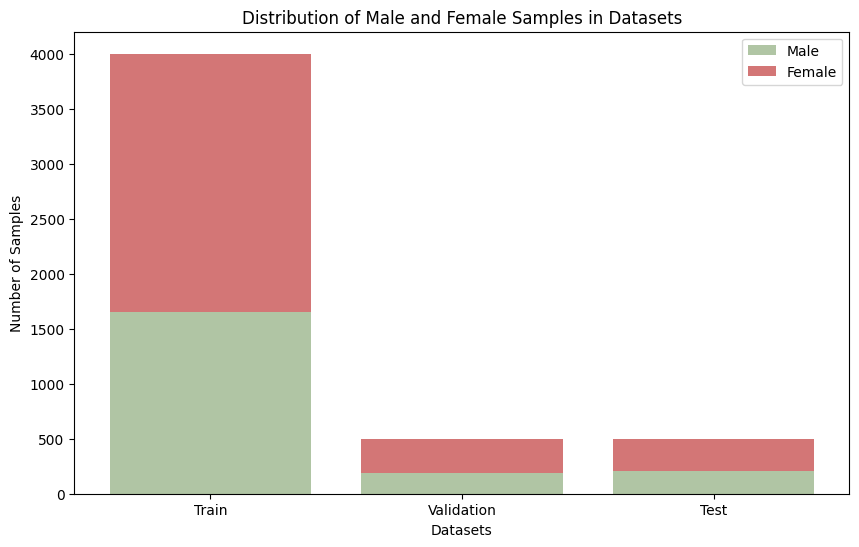

In [11]:
# Counting the number of male and female samples in each dataset
train_male_count = len(os.listdir(os.path.join(train_folder, 'Male')))
train_female_count = len(os.listdir(os.path.join(train_folder, 'Female')))

validation_male_count = len(os.listdir(os.path.join(validation_folder, 'Male')))
validation_female_count = len(os.listdir(os.path.join(validation_folder, 'Female')))

test_male_count = len(os.listdir(os.path.join(test_folder, 'Male')))
test_female_count = len(os.listdir(os.path.join(test_folder, 'Female')))

# Data
categories = ['Train', 'Validation', 'Test']
male_counts = [train_male_count, validation_male_count, test_male_count]
female_counts = [train_female_count, validation_female_count, test_female_count]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(categories, male_counts, color='#B0C5A4', label='Male')
plt.bar(categories, female_counts, color='#D37676', label='Female', bottom=male_counts)

# Add labels and title
plt.xlabel('Datasets')
plt.ylabel('Number of Samples')
plt.title('Distribution of Male and Female Samples in Datasets')
plt.legend()

# Show plot
plt.show()

# **Data Modeling**

Initialize the config :
1. image_size (this is image size from the dataset 178x218px
2. batch_size (number of batches, we will try use 32 value)
3. epochs = ( refers to one complete pass through the entire training dataset, we will use 100)

In [12]:
image_size=(178, 218);
batch_size=32;
epochs = 100
hp_opz = ['hyperband', 'RandomSearch', 'Bayesian']

### **Train Datasets**

The label mode use 'binary' because have class 1 and 0, and we found 4000 files for train dataset

In [13]:
# Load the CelebA dataset Train
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_folder,
    seed=random.randint(1, 1000),
    class_names=os.listdir(train_folder),
    # label_mode='binary',
    image_size=image_size,
    batch_size=batch_size
)

Found 4000 files belonging to 2 classes.


In [14]:
train_data_batches = [(data.numpy(), labels.numpy()) for data, labels in train_ds]
train_data, train_labels = zip(*train_data_batches)
train_data = np.vstack(train_data)
train_labels = np.hstack(train_labels)

### **Validation Datasets**

The label mode use 'binary' because have class 1 and 0, and we found 500 files for train dataset

In [15]:
# Load the CelebA dataset validation
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=validation_folder,
    seed=random.randint(1, 1000),
    class_names=os.listdir(validation_folder),
    # label_mode='binary',
    image_size=image_size,
    batch_size=batch_size
)


Found 500 files belonging to 2 classes.


In [16]:
validation_data_batches = [(data.numpy(), labels.numpy()) for data, labels in validation_ds]
validation_data, validation_labels = zip(*validation_data_batches)
validation_data = np.vstack(validation_data)
validation_labels = np.hstack(validation_labels)

### **Test Datasets**


The label mode use 'binary' because have class 1 and 0, and we found 500 files for train dataset

In [39]:
# load the CelebA dataset test
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_folder,
    seed=random.randint(1, 1000),
    # label_mode='binary',
    class_names=os.listdir(validation_folder),
    image_size=image_size,
    batch_size=batch_size
)


Found 500 files belonging to 2 classes.


In [40]:
test_data_batches = [(data.numpy(), labels.numpy()) for data, labels in test_ds]
test_data, test_labels = zip(*test_data_batches)
test_data = np.vstack(test_data)
test_labels = np.hstack(test_labels)

### **Build the Model**

The following code cell that implements the ResNet-50 architecture is a derivative of the code provided at https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50.

1. **Input Shape:** Defines the input shape of the images as (178, 218, 3).
2. **Base Model:** Loads the pre-trained ResNet50 model with weights from the ImageNet dataset and excludes the top classification layer.
3. **Freezing Layers:** Freezes all layers in the base model to prevent them from being trained.
4. **Feature Extraction:** Adds layers for average pooling and flattening to extract features from the base model's output.
5. **Hidden Layers:** Adds a customizable number of hidden layers, with their units and dropout rates defined by hyperparameters.
6. **Output Layer:** Defines the output layer with a sigmoid activation function for binary classification (male or female).
7. **Model Compilation:** Compiles the model using a chosen optimizer (Adam, RMSprop, or SGD), learning rate, and binary cross-entropy loss function.
8. **Hyperparameter Tuning:** The architecture allows for hyperparameter tuning using Keras Tuner to find the optimal combination of hidden layers, units, dropout rates, optimizer, and learning rate.
9. **Returns:** Returns the compiled ResNet50-based model for gender classification.

In [20]:
def build_resnet101(hp):
    input_shape = (178, 218, 3)
    base_model = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    num_hidden_layers = hp.Int('num_hidden_layers', min_value=1, max_value=5, step=1)
    for i in range(num_hidden_layers):
        num_units = hp.Choice(f'num_units_{i}', values=[128, 256, 512])
        dropout_rate = hp.Float(f'dropout_rate_{i}', min_value=0.1, max_value=0.9, step=0.1)

        x = Dense(num_units, activation='relu')(x)
        x = Dropout(dropout_rate)(x)

    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=outputs)

    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    learning_rate = hp.Choice('learning_rate', values=[1e-5, 1e-4, 1e-3, 3e-3, 1e-2, 3e-2, 0.1, 0.3])

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

## Hyperparameter Tuning

We will use some optimization like Hyperband, Random Search & Bayesian

## Hyperband Tuning


This is the initialization of a Hyperband tuner used to search for hyperparameters using the build_resnet50 model. The objective is to improve validation accuracy (val_accuracy) within the specified maximum number of epochs (max_epochs). The reduction factor (factor) is employed to decrease the number of models evaluated at each iteration. The storage directory (directory) is designated to store the results of hyperparameter search, and the project name (project_name) is derived from the optimal outcome of hyperparameter optimization.

In [21]:
hyperband_tuner = kt.Hyperband(
    build_resnet101,
    objective='val_accuracy',
    max_epochs=epochs,
    factor=3,
    seed=42,
    directory='/content/drive/MyDrive/ResNet/tuner',
    project_name=str(hp_opz[0])
)


Reloading Tuner from /content/drive/MyDrive/ResNet/tuner/hyperband/tuner0.json


In [ ]:
# Start the hyperparameter search
hyperband_tuner.search(train_ds, validation_data=validation_ds, epochs=epochs)


This code is used to obtain the best parameters from tuning using the Hyperband tuner. Then, the best model is built based on these parameters and trained with training and validation data. During training, ModelCheckpoint is used to save the best model based on the loss on the validation data, while EarlyStopping is used to stop training if there is no improvement in the validation loss.
We will save the model to path : /content/drive/MyDrive/ResNet/Model/

In [32]:
best_hyperband_param = hyperband_tuner.get_best_hyperparameters(num_trials=1)[0]

cp = ModelCheckpoint('/content/drive/MyDrive/ResNet/Model/Restnet101-with-{}-Optimization.h5'.format(hp_opz[0]), monitor='val_loss', save_best_only=True,
                     save_weights_only=False, mode='auto', save_freq='epoch', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=25)

best_hyperband_model = hyperband_tuner.hypermodel.build(best_hyperband_param)
best_hyperband_model = best_hyperband_model.fit(train_ds, validation_data=(test_ds), epochs=epochs,
                                                batch_size=batch_size, callbacks=[cp, early_stopping], shuffle=True)

Epoch 1/100
125/125 [==============================] - ETA: 0s - loss: 0.4883 - accuracy: 0.7903
Epoch 1: val_loss improved from inf to 3.24921, saving model to /content/drive/MyDrive/ResNet/Model/Restnet101-with-hyperband-Optimization.h5
125/125 [==============================] - 19s 91ms/step - loss: 0.4883 - accuracy: 0.7903 - val_loss: 3.2492 - val_accuracy: 0.0900
Epoch 2/100
125/125 [==============================] - ETA: 0s - loss: 0.2539 - accuracy: 0.9043
Epoch 2: val_loss did not improve from 3.24921
125/125 [==============================] - 9s 66ms/step - loss: 0.2539 - accuracy: 0.9043 - val_loss: 3.6457 - val_accuracy: 0.0920
Epoch 3/100
125/125 [==============================] - ETA: 0s - loss: 0.2219 - accuracy: 0.9133
Epoch 3: val_loss did not improve from 3.24921
125/125 [==============================] - 9s 66ms/step - loss: 0.2219 - accuracy: 0.9133 - val_loss: 5.0493 - val_accuracy: 0.0880
Epoch 4/100
125/125 [==============================] - ETA: 0s - loss: 0.201

### Random Search Tuning

This code initializes a RandomSearch tuner to search for optimal hyperparameters for the ResNet50 model. It will run a maximum of 10 trials, each with a different set of hyperparameters. The objective is to maximize validation accuracy. The results will be saved in a directory named 'tuner' with a project name based on the specified hyperparameter optimization method.

In [24]:
randomsearch_tuner = kt.RandomSearch(
    build_resnet101,
    objective='val_accuracy',
    max_trials=10,
    seed=42,
    executions_per_trial=1,
    directory='tuner',
    project_name=str(hp_opz[1])
)

In [ ]:
best_randomsearch_param = {}
randomsearch_tuner.search(train_ds, validation_data=(validation_ds), epochs=epochs, batch_size=batch_size, shuffle=True)

randomsearch_results = randomsearch_tuner.results_summary()

same like hyperband, best model will save in directory : /content/drive/MyDrive/ResNet/Model/

In [31]:
best_randomsearch_param = randomsearch_tuner.get_best_hyperparameters(num_trials=1)[0]

cp = ModelCheckpoint('/content/drive/MyDrive/ResNet/Model/Restnet101-with-{}-Optimization.h5'.format(hp_opz[1]), monitor='val_loss', save_best_only=True,
                     save_weights_only=False, mode='auto', save_freq='epoch', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=25)

best_randomsearch_model = randomsearch_tuner.hypermodel.build(best_randomsearch_param)
best_randomsearch_model = best_randomsearch_model.fit(train_ds, validation_data=(test_ds), epochs=epochs,
                                                batch_size=16, callbacks=[cp, early_stopping], shuffle=True)

Epoch 1/100


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7f686e840ca0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


KeyboardInterrupt: 

### Bayesian Tuning

Initializes a Bayesian Optimization tuner to search for optimal hyperparameters for the ResNet50 model. It will run a maximum of 10 trials, aiming to maximize validation accuracy. The results will be saved in a directory named 'tuner' with a project name based on the specified hyperparameter optimization method.

In [27]:
bayesian_tuner = kt.BayesianOptimization(
    build_resnet101,
    objective='val_accuracy',
    max_trials=10,
    seed=42,
    directory='tuner',
    project_name=str(hp_opz[2])
)

In [ ]:
best_bayesian_param = {}
bayesian_tuner.search(train_ds, validation_data=(validation_ds), epochs=epochs, batch_size=batch_size, shuffle=True)

bayesian_results = bayesian_tuner.results_summary()

same like hyperband & random search, best model will save in directory : /content/drive/MyDrive/ResNet/Model/

In [29]:
best_bayesian_param = bayesian_tuner.get_best_hyperparameters(num_trials=1)[0]

cp = ModelCheckpoint('/content/drive/MyDrive/ResNet/Model/ResNet101-with-{}-Optimization.h5'.format(hp_opz[2]), monitor='val_loss', save_best_only=True,
                     save_weights_only=False, mode='auto', save_freq='epoch', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=25)

best_bayesian_model = bayesian_tuner.hypermodel.build(best_bayesian_param)
best_bayesian_model = best_bayesian_model.fit(train_ds, validation_data=(test_ds), epochs=epochs,
                                                batch_size=16, callbacks=[cp, early_stopping], shuffle=True)

Epoch 1/100
125/125 [==============================] - ETA: 0s - loss: 0.3053 - accuracy: 0.8698
Epoch 1: val_loss improved from inf to 3.40252, saving model to /content/drive/MyDrive/ResNet/Model/ResNet101-with-Bayesian-Optimization.h5
125/125 [==============================] - 19s 93ms/step - loss: 0.3053 - accuracy: 0.8698 - val_loss: 3.4025 - val_accuracy: 0.0920
Epoch 2/100
125/125 [==============================] - ETA: 0s - loss: 0.2272 - accuracy: 0.9080
Epoch 2: val_loss did not improve from 3.40252
125/125 [==============================] - 9s 67ms/step - loss: 0.2272 - accuracy: 0.9080 - val_loss: 4.0090 - val_accuracy: 0.0900
Epoch 3/100
125/125 [==============================] - ETA: 0s - loss: 0.2011 - accuracy: 0.9208
Epoch 3: val_loss did not improve from 3.40252
125/125 [==============================] - 9s 66ms/step - loss: 0.2011 - accuracy: 0.9208 - val_loss: 5.1022 - val_accuracy: 0.0840
Epoch 4/100
125/125 [==============================] - ETA: 0s - loss: 0.1881 

In [43]:
resnet101_hyperband = load_model('/content/drive/MyDrive/ResNet/Model/Restnet101-with-hyperband-Optimization.h5')

loss, accuracy = resnet101_hyperband.evaluate(test_ds)
print(f'RestNet101 with Hyperband Tuning model loss: {loss}, accuracy: {accuracy}')

16/16 [==============================] - 3s 54ms/step - loss: 0.2092 - accuracy: 0.9100
RestNet101 with Hyperband Tuning model loss: 0.20921798050403595, accuracy: 0.9100000262260437


In [41]:
resnet101_random_search = load_model('/content/drive/MyDrive/ResNet/Model/Restnet101-with-RandomSearch-Optimization.h5')

loss, accuracy = resnet101_random_search.evaluate(test_ds)
print(f'RestNet101 with Random Search Tuning model loss: {loss}, accuracy: {accuracy}')

16/16 [==============================] - 3s 52ms/step - loss: 0.2309 - accuracy: 0.9160
RestNet101 with Random Search Tuning model loss: 0.23087573051452637, accuracy: 0.9160000085830688


In [42]:
resnet101_bayesian = load_model('/content/drive/MyDrive/ResNet/Model/ResNet101-with-Bayesian-Optimization.h5')

loss, accuracy = resnet101_bayesian.evaluate(test_ds)
print(f'RestNet101 with Random Search Tuning model loss: {loss}, accuracy: {accuracy}')

16/16 [==============================] - 4s 52ms/step - loss: 0.2060 - accuracy: 0.9080
RestNet101 with Random Search Tuning model loss: 0.2060198038816452, accuracy: 0.9079999923706055


# **Evaluation Model**

We will use Confusion Matrix for evaluation

## Confusion Matrix for Hyperband

16/16 [==============================] - 3s 46ms/step
              precision    recall  f1-score   support

           0       0.87      0.92      0.89       204
           1       0.94      0.91      0.92       296

    accuracy                           0.91       500
   macro avg       0.91      0.91      0.91       500
weighted avg       0.91      0.91      0.91       500



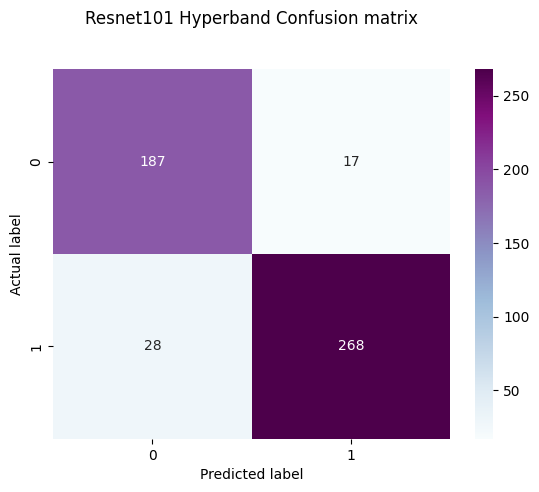

In [44]:
resnet101_hyperband_prediction = resnet101_hyperband.predict(test_data)
cnf_matrix = confusion_matrix(test_labels, np.round(resnet101_hyperband_prediction))

p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="BuPu" ,fmt='g')
plt.title('Resnet101 Hyperband Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(classification_report(test_labels, np.round(resnet101_hyperband_prediction)))

## Confusion Matrix for Random Search

16/16 [==============================] - 3s 47ms/step
              precision    recall  f1-score   support

           0       0.93      0.86      0.89       204
           1       0.91      0.95      0.93       296

    accuracy                           0.92       500
   macro avg       0.92      0.91      0.91       500
weighted avg       0.92      0.92      0.92       500



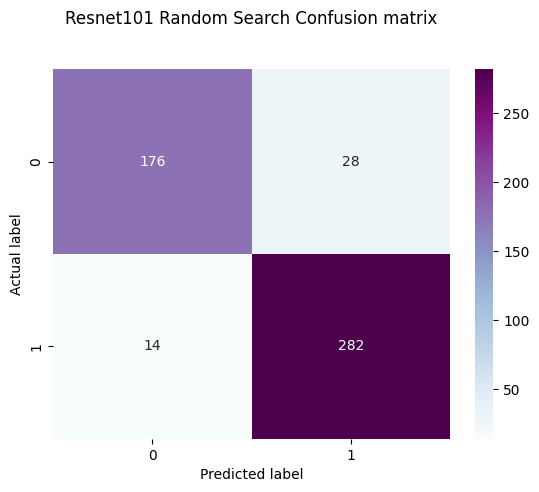

In [45]:
resnet101_randomsearch_prediction = resnet101_random_search.predict(test_data)
cnf_matrix = confusion_matrix(test_labels, np.round(resnet101_randomsearch_prediction))

p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="BuPu" ,fmt='g')
plt.title('Resnet101 Random Search Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(classification_report(test_labels, np.round(resnet101_randomsearch_prediction)))

## Confusion Matrix for Bayesian

16/16 [==============================] - 2s 45ms/step
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       204
           1       0.94      0.91      0.92       296

    accuracy                           0.91       500
   macro avg       0.90      0.91      0.91       500
weighted avg       0.91      0.91      0.91       500



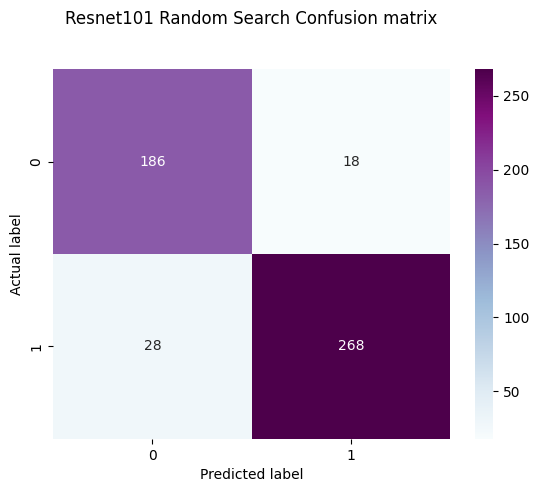

In [46]:
resnet101_bayesian_prediction = resnet101_bayesian.predict(test_data)
cnf_matrix = confusion_matrix(test_labels, np.round(resnet101_bayesian_prediction))

p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="BuPu" ,fmt='g')
plt.title('Resnet101 Random Search Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(classification_report(test_labels, np.round(resnet101_bayesian_prediction)))

1/1 [==============================] - 0s 38ms/step


<ipython-input-49-af35ca0d76e1>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_label = class_names[int(np.round(predictions[i]))]


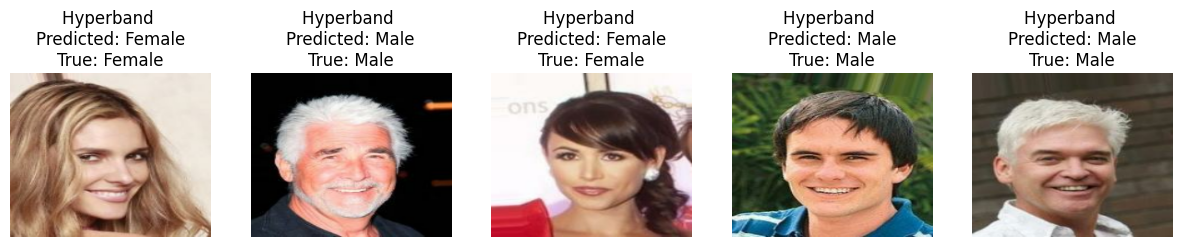

1/1 [==============================] - 0s 44ms/step


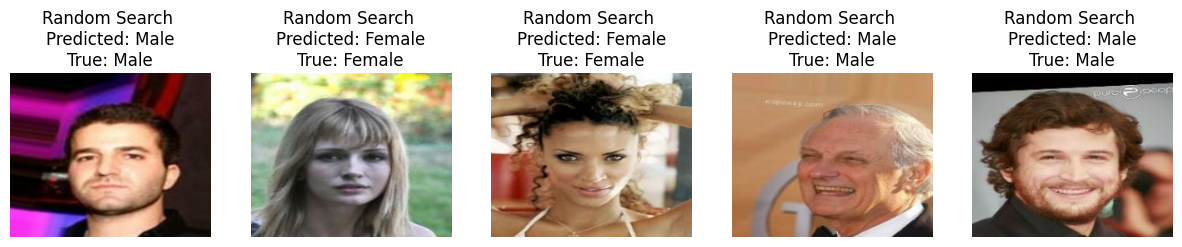

1/1 [==============================] - 0s 44ms/step


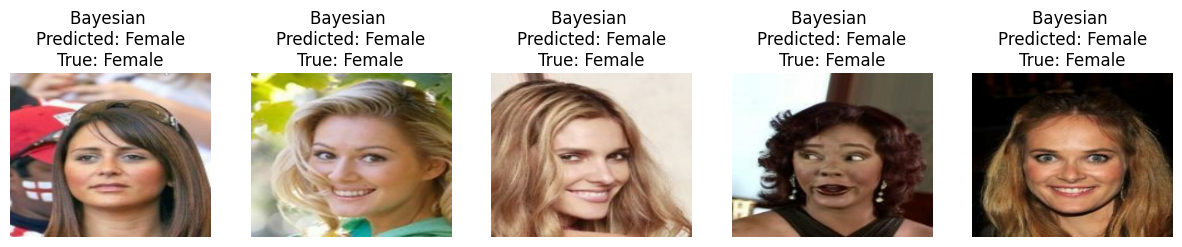

In [49]:
def display_sample_predictions(model_name,model, dataset, class_names, num_samples=5):
    plt.figure(figsize=(15, 10))
    for images, labels in dataset.take(1):
        predictions = model.predict(images)
        for i in range(num_samples):
            ax = plt.subplot(1, num_samples, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            predicted_label = class_names[int(np.round(predictions[i]))]
            true_label = class_names[int(labels[i])]
            plt.title(f'{model_name}\nPredicted: {predicted_label}\nTrue: {true_label}')
            plt.axis("off")

# Load the class names
class_names = train_ds.class_names

display_sample_predictions("Hyperband ",resnet101_hyperband, test_ds, class_names)
plt.show()

display_sample_predictions("Random Search ",resnet101_random_search, test_ds, class_names)
plt.show()

display_sample_predictions("Bayesian ",resnet101_bayesian, test_ds, class_names)
plt.show()

### **Test with another figure**

In [51]:
image_path = '/content/drive/MyDrive/ResNet/TesFigureIndonesia/tes1.jpeg'

# Load the image and resize it to the size expected by the model (178x218)
img = image.load_img(image_path, target_size=(178, 218))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Reshape it to a shape that can be accepted by the model (adding batch dimension)
img_array = np.expand_dims(img_array, axis=0)

# Normalize the pixel values
img_array /= 255.0

# Perform prediction using the loaded model
predictions_hyperband = resnet101_hyperband.predict(img_array)
predictions_random_search = resnet101_random_search.predict(img_array)
predictions_bayesian = resnet101_bayesian.predict(img_array)

threshold = 0.5

1/1 [==============================] - 0s 28ms/step


### **Hyperband**

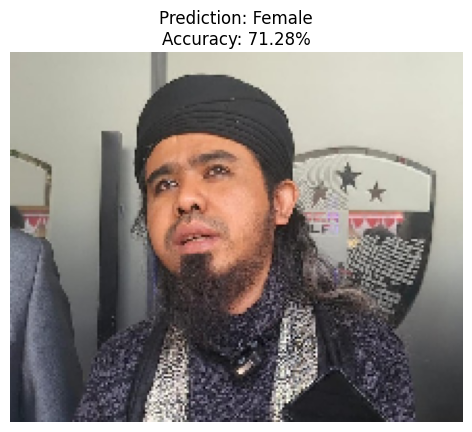

In [52]:
predicted_class = "Male" if predictions_hyperband[0][0] > threshold else "Female"
accuracy_percentage = predictions_hyperband[0][0] if predicted_class == "Male" else 1 - predictions_hyperband[0][0]

# Display the image
plt.imshow(img)
plt.axis('off')
plt.title(f'Prediction: {predicted_class}\nAccuracy: {accuracy_percentage * 100:.2f}%')
plt.show()


### **Random Search**

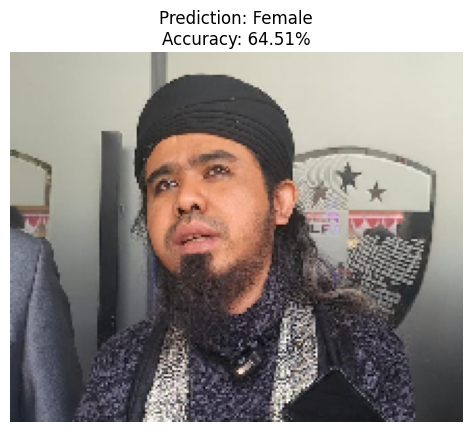

In [53]:
predicted_class = "Male" if predictions_random_search[0][0] > threshold else "Female"
accuracy_percentage = predictions_random_search[0][0] if predicted_class == "Male" else 1 - predictions_random_search[0][0]

# Display the image
plt.imshow(img)
plt.axis('off')
plt.title(f'Prediction: {predicted_class}\nAccuracy: {accuracy_percentage * 100:.2f}%')
plt.show()


### **Bayesian**

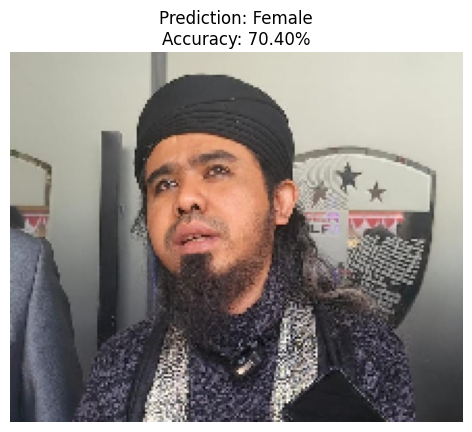

In [54]:
predicted_class = "Male" if predictions_bayesian[0][0] > threshold else "Female"
accuracy_percentage = predictions_bayesian[0][0] if predicted_class == "Male" else 1 - predictions_bayesian[0][0]

# Display the image
plt.imshow(img)
plt.axis('off')
plt.title(f'Prediction: {predicted_class}\nAccuracy: {accuracy_percentage * 100:.2f}%')
plt.show()
